In [1]:
# General 
import numpy as np
import pandas as pd
from scipy import stats
# Plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
# Connectomes and network analysis
import conntility
# Specific to this project
import sys 
sys.path.append('../../../library')
from structural_basic import load_connectome
from utils_microns_bbp import *
from plotting_utils import *

In [2]:
configs={} #Paths to activity and structural data 

# Paths to data and specs 
configs["BBP"]={
    "connectome_dir":"../../data",
    "simplicial_dir":"../../data",
    "fname_reliability":"/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/simulations/BlobStimReliability_O1v5-SONATA_Baseline/working_dir/reliability_basic.npz",
    "fname_CC": "/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/bbp_workflow/7b381e96-91ac-4ddd-887b-1f563872bd1c/working_dir/coupling_coefficients.pkl",
    "norm_types": ["global", "per_cell"],
    "fname_rates":"/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/bbp_workflow/7b381e96-91ac-4ddd-887b-1f563872bd1c/toposample_input/raw_spikes_exc.npy",
    "format_rates":"toposample",
    "bin_size":"2p0", 
    "fname_effciency":"/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/simulations/Toposample_O1v5-SONATA/working_dir/dimensions_EE_from_signals.pkl",
    "properties":["CC", "CC_norm_cell", "reliability", "efficiency"], 
    "stypes":["all", "maximal"],
    "base_graph": "original"
}

configs["MICrONS"]={
    "connectome_dir":"../../data",
    "simplicial_dir":"../../data",
    "fname_reliability":"/gpfs/bbp.cscs.ch/project/proj96/home/ecker/assemblyfire/MICrONS/MICrONS_functional_summary.pkl",
    "fname_CC": "/gpfs/bbp.cscs.ch/project/proj96/home/ecker/assemblyfire/MICrONS/MICrONS_functional_summary.pkl",
    "norm_types": ["global", "per_cell"],
    "fname_rates": "/gpfs/bbp.cscs.ch/project/proj96/home/ecker/assemblyfire/MICrONS/MICrONS_functional_summary.pkl",
    "format_rates":None,
    "bin_size":None, 
    "save_dir":"../../data", 
    "average_type":["per_layer", "full"], 
    "properties":["CC", "CC_norm_cell", "reliability"], 
    "stypes":["all", "maximal"],
    "base_graph": "original"
}

connectomes, simp_layer_raw, simp_full_raw ={}, {}, {}

#Load precomputed data 
conns=["MICrONS", "BBP"]
for conn in conns:
    cfg=configs[conn]
    stypes=cfg["stypes"]
    base_graph=cfg["base_graph"]
    # Get connectome and porperties per node 
    connectome=load_connectome(cfg["connectome_dir"], conn)
    connectome = add_layers(connectome,conn)
    connectome = add_reliability(connectome, conn, cfg["fname_reliability"])
    connectome = add_firing_rates(connectome,conn, cfg["fname_rates"], cfg["format_rates"]) 
    for norm_type in cfg["norm_types"]:
        connectome = add_cc(connectome, cfg["fname_CC"], norm_type)#, bin_size=cfg["bin_size"]) double check bin size option 
    connectomes[conn]=connectome
    # Adding properties of neighbohoords 
    nbd_props=pd.read_pickle(f'/gpfs/bbp.cscs.ch/home/egassant/reliability_and_structure/data_analysis/data/props_{conn}_original.pkl')
    for col in nbd_props.columns:
        connectomes[conn].add_vertex_property(new_label=col,new_values=nbd_props[col].to_numpy())
    
# Load dimension of activity (BBP only)
conn="BBP"
connectomes[conn]=add_efficiency(connectomes[conn], configs[conn]["fname_effciency"])


In [3]:
# Get top and bottom complexity neighborhoods with active centers
complexity_metric="euclidean_edges_sc"
for conn in conns:
    df=connectomes[conn].vertices
    activity_properties = ["CC_norm_cell", "efficiency"] if conn == "BBP" else ["CC_norm_cell"]
    for activity_property in activity_properties:
        tresh=100/(~np.isnan(df[activity_property])).sum() # Fixed sample size 100 centers
        # Restrict to centers with co-registered activity metric
        x=(df[~np.isnan(df[activity_property])])[complexity_metric] 
        df[('nbd_complexity', activity_property)]=np.nan
        # Sparse ones
        df[('nbd_complexity', activity_property)][df[complexity_metric]<np.quantile(x, tresh)]='low complexity'
        # Dense ones
        df[('nbd_complexity', activity_property)][df[complexity_metric]>np.quantile(x, 1-tresh)]='high complexity'
        connectomes[conn].add_vertex_property(new_label=('nbd_complexity', activity_property),new_values=df[('nbd_complexity', activity_property)].to_numpy())



/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2379623/ipykernel_197373/1255314741.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[('nbd_complexity', activity_property)][df[complexity_metric]<np.quantile(x, tresh)]='low complexity'
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2379623/ipykernel_197373/1255314741.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[('nbd_complexity', activity_property)][df[complexity_metric]<np.quantile(x, tresh)]='low complexity'
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2379623/ipykernel_197373/1255314741.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

# Plotting basics 

In [4]:
# Figure settings and color schemes 
titlesize=8
labelsize=6
ticksize=6
conversion=2.54
#conversion=1.5

marker_size=2
linewidth=2; linewidth_base=1; linestyle_base="dotted"; alpha_base=0.75

# Setting up colors 
colors={
    'high complexity': 'tab:purple', 
    'low complexity': 'tab:cyan', 
    2:matplotlib.colormaps["Set3"](0),
    3:matplotlib.colormaps["Set3"](2),
    4:matplotlib.colormaps["Set3"](5),
    5:matplotlib.colormaps["Set3"](4),
    6:matplotlib.colormaps["Set3"](3),
    "all":"C0",
    "sink": "C1",
    "source":"C2"
}
markers={"all":"o",
       "sink": ">",
       "source":"<"}
alpha=0.25

# Simplicial structure 

In [5]:
# Get simplicial structure  
for conn in conns: 
    cfg=configs[conn]
    simp_layer_raw[conn], simp_full_raw[conn] ={}, {}
    for property in cfg["properties"]:
        fname=f"{cfg['simplicial_dir']}/node_stats_per_layer_{property}_{conn}_{base_graph}.pkl"
        simp_layer_raw[conn][property]=pd.read_pickle(fname)
        fname=f"{cfg['simplicial_dir']}/node_stats_full_{property}_{conn}_{base_graph}.pkl"
        simp_full_raw[conn][property]=pd.read_pickle(fname)

# Reformat for plotting 
simplicial_full=agg_along_dims_single(simp_full_raw)
simplicial_layers=agg_along_dims_layers(simp_layer_raw)


In [6]:
def plot_and_fill_all_positions(ax, dict, colors, marker_size, markers, alpha):
    for pos in ["source", "all", "sink"]: 
        df=dict[pos]
        plot_and_fill(ax, df, pos, colors[pos], marker_size, markers[pos], alpha)                        
    ax.spines[["top", "right"]].set_visible(False)
    ax.tick_params(labelsize=ticksize)
    h,l = ax.get_legend_handles_labels()
    return ax,h,l

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2379623/ipykernel_197373/3358910662.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dummy"]=1
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2379623/ipykernel_197373/3358910662.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dummy"]=1
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2379623/ipykernel_197373/3358910662.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =



For connectome MICrONS
Sample size 100, 100
Kruskal-Wallis H-test KruskalResult(statistic=8.597014925373173, pvalue=0.0033671446007538246)


For connectome BBP
Sample size 100, 100
Kruskal-Wallis H-test KruskalResult(statistic=116.58245373134332, pvalue=3.543372229255727e-27)


For connectome BBP
Sample size 100, 100
Kruskal-Wallis H-test KruskalResult(statistic=141.65488161803813, pvalue=1.157028423419162e-32)


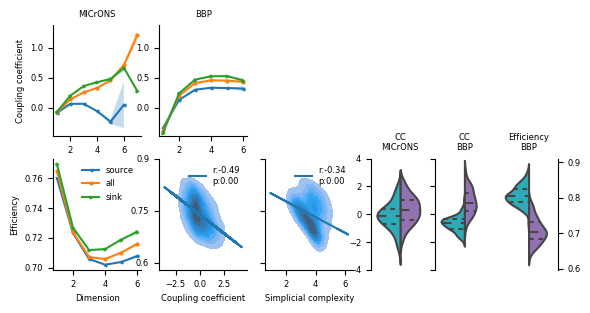

In [7]:
width=21*0.8/conversion
fig, axes =plt.subplot_mosaic([['00', '01', '02', '03', '03'],
                              ['10', '11', '12', '13', '13']], 
                             figsize=(width*1, width*2*1.2/5))
axs=np.array([[axes['00'], axes['01'],axes['02']],
              [axes['10'], axes['11'],axes['12']]])

#### Simplicial structure
stype="maximal" # Consider maximal simplices
# Coupling 
property="CC_norm_cell"
for i, conn in enumerate(conns):
    dict=simplicial_full[conn][property][stype] 
    axs[0,i], h,l =plot_and_fill_all_positions(axs[0,i], dict, colors, marker_size, markers, alpha)
    axs[0,i].set_xlabel("Dimension", fontsize=labelsize)
    axs[0,i].set_title(conn, fontsize=labelsize)

# Make shared axis 
y_min=min(axs[0,0].get_ylim()[0], axs[0,1].get_ylim()[0])
y_max=max(axs[0,0].get_ylim()[1], axs[0,1].get_ylim()[1])
for ax in [axs[0,0], axs[0,1]]:
    ax.set_ylim(y_min, y_max)
    ax.set_xticks([2,4,6])
# Leave space for cartoon 
for ax in [axes['02'], axes['03']]: 
    ax.axis("off")

axs[0,0].set_ylabel("Coupling coefficient", fontsize=labelsize)

# Efficiency
property="efficiency"
conn="BBP"
dict=simplicial_full[conn][property][stype] 
axs[1,0], h,l =plot_and_fill_all_positions(axs[1,0], dict, colors, marker_size, markers, alpha)
axs[1,0].legend(frameon=False, ncols=1, fontsize=labelsize)#,loc="center", bbox_to_anchor=(0.5, -0.33),)'''



#### Scatter and regression
conn="BBP"
df=connectomes[conn].vertices
y=df["efficiency"].astype("float")
color="C0"#df["rates"]
for i, x_prop in enumerate(["CC_norm_cell", complexity_metric], start=1):
    x=df[x_prop].astype("float")
    axs[1,i], h, l, regress=kde_and_regress(axs[1,i],df,x=x_prop, y="efficiency", color=color, return_stats=True)
    axs[1,i].set_yticks([0.9, 0.75, 0.6],[0.9, 0.75, 0.6])
    if i>1: axs[1,i].set_yticks([0.9, 0.75, 0.6], ["", "", ""])
    axs[1,i].spines[["top", "right"]].set_visible(False) 
    axs[1,i].legend([h[0]], [f"r:{regress.rvalue:.2f}\np:{regress.pvalue:.2f}"], frameon=False, fontsize=labelsize, loc="upper right")
    axs[1,0].set_ylabel("Efficiency", fontsize=labelsize)
axs[1,0].set_xlabel("Dimension", fontsize=labelsize)
axs[1,1].set_xlabel("Coupling coefficient", fontsize=labelsize)
axs[1,2].set_xlabel("Simplicial complexity", fontsize=labelsize)

for ax in axs.flatten():
    ax.tick_params(labelsize=ticksize)

#### Extremals 
axes['13'].axis("off")
ax_extremals=[]
x0, y0, width, height=0,0, 0.3, 1
for x0 in [0, 0.33, 0.66]:
    ax_extremals.append(axes['13'].inset_axes([x0, y0, width, height])) 


for i, conn in enumerate(conns+["BBP"]):
    property="CC_norm_cell" if i<2 else "efficiency"
    df=connectomes[conn].vertices
    data=df[np.logical_or(df[("nbd_complexity", property)]=="high complexity", 
                          df[("nbd_complexity", property)]=="low complexity")]
    data["dummy"]=1
    x=data[data[('nbd_complexity', property)]== 'low complexity'][property].to_numpy()
    y=data[data[('nbd_complexity', property)]== 'high complexity'][property].to_numpy()
    x=x[~np.isnan(x)]; y=y[~np.isnan(y)]
    print(f"\n\nFor connectome {conn}")
    print(f"Sample size {x.shape[0]}, {y.shape[0]}")
    print(f"Kruskal-Wallis H-test {stats.kruskal(x, y)}")
    
    #Plot violins 
    ax_extremals[i]=plot_violin(ax_extremals[i], y=property, data=data, hue=("nbd_complexity", property))
    ax_extremals[i].get_legend().remove()
    ax_extremals[i].tick_params(axis='both', labelsize=ticksize)
    ax_extremals[i].set_ylabel("",fontsize=labelsize) 

    if i<2:
        ax_extremals[i].set_ylim([-4,4])
        ax_extremals[i].spines[["right", "top", "bottom"]].set_visible(False)
    else:
        ax_extremals[i].spines[["left", "top", "bottom"]].set_visible(False)
        ax_extremals[i].yaxis.tick_right()
        ax_extremals[i].yaxis.set_label_position("right")
ax_extremals[0].set_yticks([-4,-2,0,2,4])
ax_extremals[1].set_yticks([-4,-2,0,2,4], ["", "", "", "", ""])


ax_extremals[0].set_title("CC\nMICrONS",fontsize=labelsize) 
ax_extremals[1].set_title("CC\nBBP",fontsize=labelsize) 
ax_extremals[2].set_title("Efficiency\nBBP",fontsize=labelsize) 
   
fig.savefig(f"figs/cc_efficiency_dimension_both_connectomes.pdf", transparent=True, bbox_inches="tight")

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2379623/ipykernel_197373/165221649.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dummy"]=1
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2379623/ipykernel_197373/165221649.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dummy"]=1
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2379623/ipykernel_197373/165221649.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va



For connectome MICrONS
Sample size 100, 100
Kruskal-Wallis H-test KruskalResult(statistic=8.597014925373173, pvalue=0.0033671446007538246)


For connectome BBP
Sample size 100, 100
Kruskal-Wallis H-test KruskalResult(statistic=116.58245373134332, pvalue=3.543372229255727e-27)


For connectome BBP
Sample size 100, 100
Kruskal-Wallis H-test KruskalResult(statistic=141.65488161803813, pvalue=1.157028423419162e-32)


Text(0.5, 1.0, 'Efficiency-BBP')

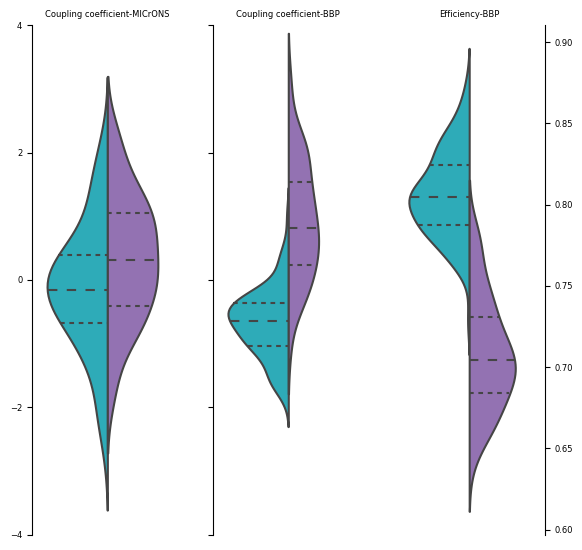

In [8]:
# Plotting extremals only and W-test
width=21*0.8/conversion

rows=1; cols=3
#fig, axs =plt.subplots(rows,cols,figsize=(width, width*rows/cols), sharex=False, sharey=False)
fig, axs =plt.subplots(rows,cols,figsize=(width, width), sharex=False, sharey=False)

# Plotting violins of extremals

for i, conn in enumerate(conns+["BBP"]):
    
    property="CC_norm_cell" if i<2 else "efficiency"
    df=connectomes[conn].vertices
    data=df[np.logical_or(df[("nbd_complexity", property)]=="high complexity", 
                          df[("nbd_complexity", property)]=="low complexity")]
    data["dummy"]=1
    x=data[data[('nbd_complexity', property)]== 'low complexity'][property].to_numpy()
    y=data[data[('nbd_complexity', property)]== 'high complexity'][property].to_numpy()
    x=x[~np.isnan(x)]; y=y[~np.isnan(y)]
    print(f"\n\nFor connectome {conn}")
    print(f"Sample size {x.shape[0]}, {y.shape[0]}")
    print(f"Kruskal-Wallis H-test {stats.kruskal(x, y)}")
    
    #Plot violins 
    axs[i]=plot_violin(axs[i], y=property, data=data, hue=("nbd_complexity", property))
    axs[i].get_legend().remove()
    axs[i].tick_params(axis='both', labelsize=ticksize)
    axs[i].set_ylabel("",fontsize=labelsize) 

    if i<2:
        axs[i].set_ylim([-4,4])
        axs[i].spines[["right", "top", "bottom"]].set_visible(False)
    else:
        axs[i].spines[["left", "top", "bottom"]].set_visible(False)
        axs[i].yaxis.tick_right()
        axs[i].yaxis.set_label_position("right")
axs[0].set_yticks([-4,-2,0,2,4])
axs[1].set_yticks([-4,-2,0,2,4], ["", "", "", "", ""])


axs[0].set_title("Coupling coefficient-MICrONS",fontsize=labelsize) 
axs[1].set_title("Coupling coefficient-BBP",fontsize=labelsize) 
axs[2].set_title("Efficiency-BBP",fontsize=labelsize) 
   
    #axs[i].yaxis.tick_right()
    #axs[i,j].yaxis.set_label_position("right")

#fig.savefig(f"figs/reliab_extremals_both_connectomes.pdf", transparent=True, bbox_inches="tight")
